In [ ]:
# drive dosya erişim
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Kütüphanleri indir
#!pip install tensorflow
#!pip install keras

In [ ]:
# Gerekli importler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint # metrik ve learning rate // en iyi ağırlık
from tensorflow.keras.optimizers import Adam

In [ ]:
# Sınıflandırma
precision = Precision()
recall = Recall()
classes_names = [
    "azami_hiz_60",
    "azami_hiz_70",
    "azami_hiz_80",
    "bisiklet_gecebilir",
    "bisiklet_yolu",
    "duraklamak_ve_park_etmek_yasak",
    "girilmez",
    "motorlu_tasit_yolu_baslangici",
    "motorlu_tasit_yolu_sonu",
    "okul_gecidi",
    "saga_donus",
    "saga_donus_yasak",
    "sesli_ikaz_cihazi_kullanimi_yasak",
    "u_donusu_yapilir"
]

In [ ]:
# Veri setinin yolu
train_data_dir = r"/content/drive/MyDrive/proje-b_dataset/train"
test_data_dir = r"/content/drive/MyDrive/proje-b_dataset/test"
valid_data_dir = r"/content/drive/MyDrive/proje-b_dataset/validation"

In [ ]:
# Veri ön işleme için ImageDataGenerator kullanma
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255, #Görüntü pikselleri
    shear_range=0.3, #açı aralığında rastgele kaydırır
    horizontal_flip=True,
    fill_mode='nearest', #boş piksel doldurma
    brightness_range=[0.2, 1.5], # Kontrast ve parlaklık ayarı
    width_shift_range=0.15,  # Yatay kaydırma
    height_shift_range=0.15,  # Dikey kaydırma
    zoom_range=0.1,  # Ölçeklendirme
    channel_shift_range=10.0  # Düşük yoğunluklu Gaussian gürültü
    )

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Veri setlerini yükleyerek ImageDataGenerator nesneleri olusturma
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=64, #bir iterasyonda işlenecek resim sayısı
    class_mode='categorical', #sınıfların kategorik (birden fazla sınıf) var
    shuffle=True #her epochta rastgele karıştırma
)

Found 1890 images belonging to 14 classes.


In [ ]:
#valid generator
validation_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 420 images belonging to 14 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
    )

Found 406 images belonging to 14 classes.


In [ ]:
# CNN modeli oluşturma
model = Sequential()

#Evrisim ve hvuzlama katmani 1 adet  adet 8 adet 3*3 boyutlu filtre
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #boyut yarıya indi

#Evrisim ve hvuzlama katmani 2
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

#Evrisim ve hvuzlama katmani 3
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

#Evrisim ve hvuzlama katmani 3
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

#Evrisim ve hvuzlama katmani 4
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

#duzlestirme katmani
model.add(GlobalAveragePooling2D())

#full connectes katman 1
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
#cikis
model.add(Dense(len(classes_names), activation='softmax'))

In [ ]:
# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy', recall, precision])

#Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005, verbose=1)#egitim esnasinda ogrenme oranini dinamik olarak ayarlar

# Model Checkpoint
checkpoint = ModelCheckpoint('best_model_cnn.h5', verbose=1, save_best_only=True, monitor='val_loss')#model egitimi esnasinda en iyi genelleme yapan agirliklari kaydeder


In [ ]:
# Modeli eğitme
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    batch_size=64,
    callbacks=[reduce_lr, checkpoint],
    shuffle=True
    )

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 2.6422 - accuracy: 0.0587 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00
Epoch 1: val_loss improved from inf to 2.63063, saving model to best_model_cnn.h5
30/30 [==============================] - 39s 1s/step - loss: 2.6422 - accuracy: 0.0587 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - val_loss: 2.6306 - val_accuracy: 0.1190 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - lr: 0.0050
Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 2.6334 - accuracy: 0.0889 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00
Epoch 2: val_loss improved from 2.63063 to 2.62982, saving model to best_model_cnn.h5
30/30 [==============================] - 36s 1s/step - loss: 2.6334 - accuracy: 0.0889 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - val_loss: 2.6298 - val_accuracy: 0.0857 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - lr: 0.0050
Epoch 3/100
30/30 [=============================

In [ ]:
# Model performansini degerlendirme
evaluation = model.evaluate((test_generator), steps=len(test_generator))
print("Test veri seti üzerinde modelin performansı: Loss={}, Accuracy={}, Precision={}, Recall={}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3]))


7/7 [==============================] - 3s 458ms/step - loss: 0.1722 - accuracy: 0.9606 - recall_2: 0.9606 - precision_2: 0.9606
Test veri seti üzerinde modelin performansı: Loss=0.17222703993320465, Accuracy=0.9605911374092102, Precision=0.9605911374092102, Recall=0.9605911374092102


dict_keys(['loss', 'accuracy', 'recall_2', 'precision_2', 'val_loss', 'val_accuracy', 'val_recall_2', 'val_precision_2', 'lr'])


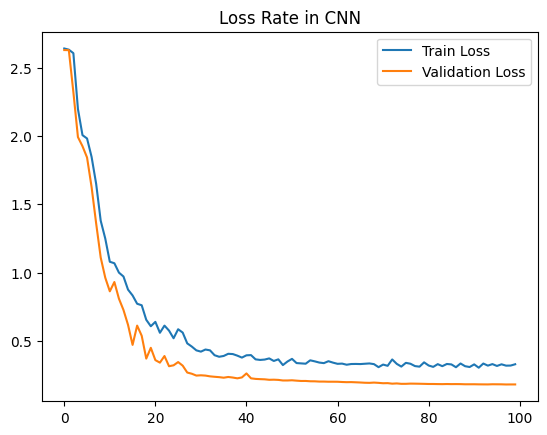

In [ ]:
#gorsellestirme
import matplotlib.pyplot as plt

print(history.history.keys())
plt.title("Loss Rate in CNN")
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
#loss ve accuracy Train uzerinde, val_loss ve val_accuracy Test uzerindeki sonuclar
plt.legend()
plt.show()

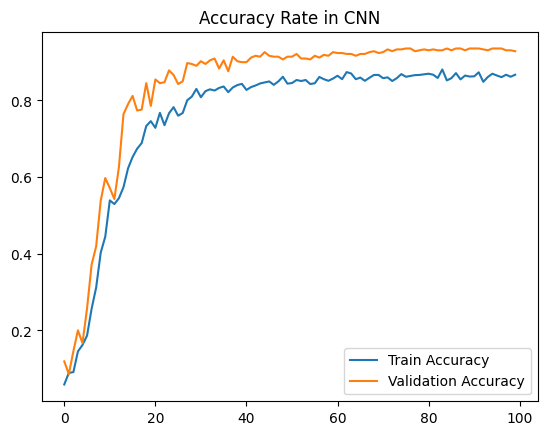

In [ ]:
plt.figure()
plt.title("Accuracy Rate in CNN")
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

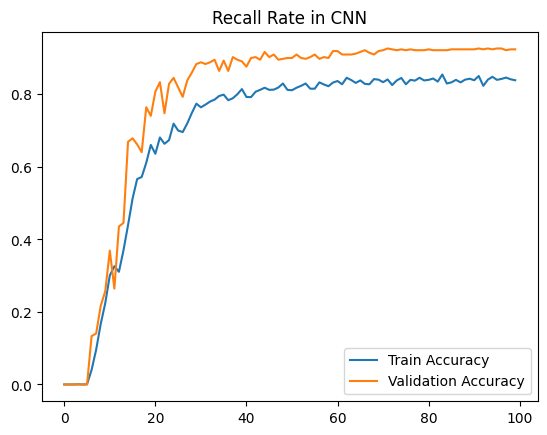

In [ ]:
plt.figure()
plt.title("Recall Rate in CNN")
plt.plot(history.history["recall_2"], label = "Train Accuracy")
plt.plot(history.history["val_recall_2"], label = "Validation Accuracy")
plt.legend()
plt.show()

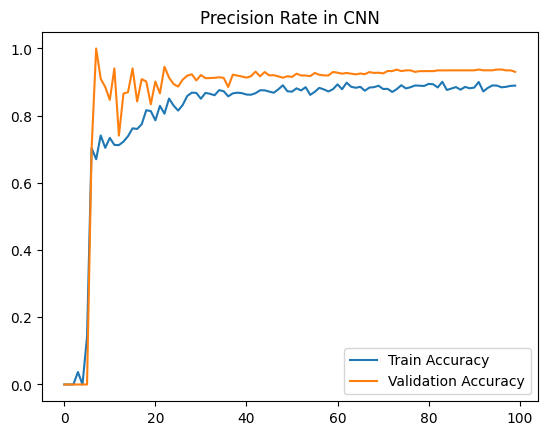

In [ ]:
plt.figure()
plt.title("Precision Rate in CNN")
plt.plot(history.history["precision_2"], label = "Train Accuracy")
plt.plot(history.history["val_precision_2"], label = "Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

#egitilmis modeli yukle
model = load_model('best_model_cnn.h5')

#tahmin edilecek goruntu yolu
image_path = r'/content/A.png'
#goruntu yukleme ve on isleme
img = image.load_img(image_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  #normalizasyon

# Tahmin yap
predictions = model.predict(img_array)

class_labels = [
    "azami_hiz_60",
    "azami_hiz_70",
    "azami_hiz_80",
    "bisiklet_gecebilir",
    "bisiklet_yolu",
    "duraklamak_ve_park_etmek_yasak",
    "girilmez",
    "motorlu_tasit_yolu_baslangici",
    "motorlu_tasit_yolu_sonu",
    "okul_gecidi",
    "saga_donus",
    "saga_donus_yasak",
    "sesli_ikaz_cihazi_kullanimi_yasak",
    "u_donusu_yapilir"
]

#Tahminlerin sinif etiketine donusturulmesi
predicted_classes = [class_labels[np.argmax(prediction)] for prediction in predictions]

print("Tahmin edilen sınıf:", predicted_classes[0])



1/1 [==============================] - 0s 394ms/step
Tahmin edilen sınıf: azami_hiz_60
